# Facebook Message Analyzer
##### Lars Lien Ankile

## Initial setup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Imports 
import os
import json
import numpy as np
import pylab as plt
import datetime
import glob
from datetime import datetime
from operator import itemgetter
from collections import Counter


from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [0]:
# globals 
ROOT_DIRECTORY = "/content/drive/My Drive/NTNU/6. Semester/HCS"
CURRENT_DIRECTORY = ROOT_DIRECTORY
NUMBER_TO_ANALYZE = 9000
MESSAGE_THRESHOLD = 50
MESSAGE_BOUND = 100000

# A list of words I'll consider profanity in this study
PROFANITIES = set('faen helvete fuck fitte jævla fucking fuckings shit drittsekk kuksuger kuk kukk pikk pikkhue dritt ræv hore skløtte cunt piss kjeft'.split())

## Getting and preparing the data for analyses

In [42]:
# get json data for the individual chats in your messages folder 
def get_json_data(chat_name):
    try:
        json_data = None
        # you may need to change the directory path, depends on where you've downloaded your fb messages to. 
        json_files = glob.glob(CURRENT_DIRECTORY + "/messages/inbox/" + chat_name + "/*.json")
        for json_location in json_files:
            with open(json_location) as json_file:
                data = json.load(json_file)
                if json_data is None:
                    json_data = data
                else:
                    json_data['messages'].extend(data['messages'])
        
        return json_data

    except IOError:
        print("Got IOError")
        pass # some things the directory aren't messages (DS_Store, stickers_used, etc.)


    
# create new globals for data to be plotted 
chats = os.listdir(CURRENT_DIRECTORY + "/messages/inbox")[:NUMBER_TO_ANALYZE]
print(chats)
sorted_chats = []
final_data_messages = {}
final_data_times = {}
final_data_words = {}
invalid_message_count = 0

print('Analyzing ' + str(min(NUMBER_TO_ANALYZE, len(chats))) + ' chats...')

['VictoriaPerez_z4bihMRg0g', 'Tekkers_V86gXmc1fg', 'VictoriaElisabethCavalliniFevik_7RDsHRLcfw', 'OyvindAsplin_4jSk3C2GbQ', 'VictoriaElisabethCavalliniFevikAnanthanVinayaEmilieLangeSkinstadog3andre_r1KCVc76ow', 'chingchong_ZK6Zl3izpg', 'taco_tF-txvpVrA', 'dopeboyz_balinMHunQ', 'fcXlaijpdA', 'TorHenryDyer_9rn-ZiVsKw', 'VisommeneratLarsskalsluttearinakenpakameleriNewYork_EX2PjKUBCw', 'Vors__DLzXwK5sw', 'VictoriaElisabethCavalliniFevikAnanthanVinayaEmilieLangeSkinstadog5andre_wOF8rPDmXg', 'VictoriaElisabethCavalliniFevikAnanthanVinayaFredrikShaughnessyAhlborgogIdaMariaMartinsson_OoRZFK64cQ', 'WaliGilani_UnEG2X4eXw', 'grillingpadamtjern_W3-jeMeKOw', 'VivekFredrikogLars_zspKIOJ46g', 'Vors_laZ1WOwlOQ', 'VentureCup2018_64c5mn1azg', 'psych_atelFFeygw', 'ValdemarEdvardSandalRolfsenSynneStenvoldogVemundWoien_fpQSlo6RiA', 'dolepance_N6JT_UmrIQ', 'UHSQUADGOALS_UqoTOYGmmQ', 'VegardLowe_9edTgYrcgw', 'TomAndreHaakonsen__7yNZnQJdw', 'Vors_3u_Rl43C7w', 'TheChristmasLiens_hOZpTI-G3A', 'VityasarMaheswara

In [43]:
# sort data into new gobals 
for chat in chats:
    url = chat
    json_data = get_json_data(chat)

    if json_data != None:
        messages = json_data["messages"]
        if len(messages) >= MESSAGE_THRESHOLD and len(messages) <= MESSAGE_BOUND:
            sorted_chats.append((len(messages), chat, messages))

sorted_chats.sort(reverse=True)
print('Finished processing chats...')

Finished processing chats...


## Crunching of data for visualizations

### Word frequencies -- Does my chat history follow Zipf's law?
The following code counts occurances of unique words in all my messages.

In [57]:
# Code for counting occurances of each unique word
word_count = Counter()

for i, (message_count, chat, messages) in enumerate(sorted_chats):

    for message in messages:
        try:
            if message["sender_name"] == "Lars Lien Ankile":
                
                message_content = message["content"]
                
                for word in message_content.split():
                    stripped_word = word.strip().strip('!"#$%&\'()*+, -./:;<=>?@[\]^_`{|}~').lower()
                    word_count.update([stripped_word])

        except KeyError:
            # happens for special cases like users who deactivated, unfriended, blocked
            invalid_message_count += 1



# Sort according to ratios

print('Found ' + str(invalid_message_count) + ' invalid messages...')
print('Found ' + str(len(sorted_chats)) + ' chats with ' + str(MESSAGE_THRESHOLD) + ' messages or more')

Found 58706 invalid messages...
Found 332 chats with 50 messages or more


### Profanity rate in my messages to different people -- Are some treated more harshly than others?
The following code counts the occurances of bad words per message sent to each of the chats that are analyzed and finds the ones with the highest ratio. Chats with less than 500 total messages are filtered out for more interesting results.

In [50]:
# Code for counting occurances of profanity per chat
profanity_counts = Counter()
chat_profanity_ratios = {}

for i, (message_count, chat, messages) in enumerate(sorted_chats):

    if message_count < 500:
        continue
    chat_name = chat.split('_')[0]

    if chat_name == "facebookbruker":
        continue

    for message in messages:
        try:
            name = message["sender_name"]
            message_content = message["content"]

            if name == "Lars Lien Ankile":
                for word in message_content.split():
                    if word.strip().lower() in PROFANITIES:
                        profanity_counts.update({chat_name: 1})
        except KeyError:
            # happens for special cases like users who deactivated, unfriended, blocked
            invalid_message_count += 1


    chat_profanity_ratios[chat_name] = profanity_counts[chat_name] / message_count

# Sort according to ratios
chat_profanity_ratios = list(sorted(chat_profanity_ratios.items(), key=itemgetter(1), reverse=True))

print('Found ' + str(invalid_message_count) + ' invalid messages...')
print('Found ' + str(len(sorted_chats)) + ' chats with ' + str(MESSAGE_THRESHOLD) + ' messages or more')


Found 52362 invalid messages...
Found 332 chats with 50 messages or more


### Profanity per day of the week -- Are some days better for bad words than others?
Thee following code finds the total number of bad words sent on any given day of the week and divides that by the total number of messages sent on that weekday.

In [46]:
# Code for counting rate of profanity per day of week
profanity_counts = Counter()
message_counts = Counter()

for i, (message_count, chat, messages) in enumerate(sorted_chats):

    for message in messages:
        try:
            name = message["sender_name"]
            message_content = message["content"]
            weekday_sent = datetime.fromtimestamp(message['timestamp_ms'] / 1000).weekday()

            message_counts.update({weekday_sent: 1})

            if name == "Lars Lien Ankile":
                for word in message_content.split():
                    if word.strip().lower() in PROFANITIES:
                        profanity_counts.update({weekday_sent: 1})


        except KeyError:
            # happens for special cases like users who deactivated, unfriended, blocked
            invalid_message_count += 1

# Weekday names
week_days = ["Monday", "Tuesday", "Wednessday", "Thursday", "Friday", "Saturday", "Sunday"]

# Create a plottable dict
weekday_profanity_ratios = {week_days[day]: profanity_counts[day] / message_counts[day] for day in range(7)}

print('Found ' + str(invalid_message_count) + ' invalid messages...')
print('Found ' + str(len(sorted_chats)) + ' chats with ' + str(MESSAGE_THRESHOLD) + ' messages or more')

Found 27772 invalid messages...
Found 332 chats with 50 messages or more


### Plot the results

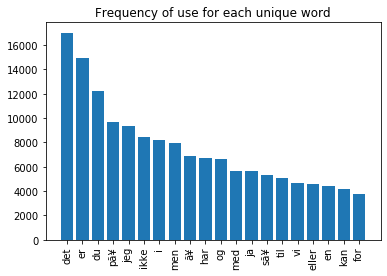

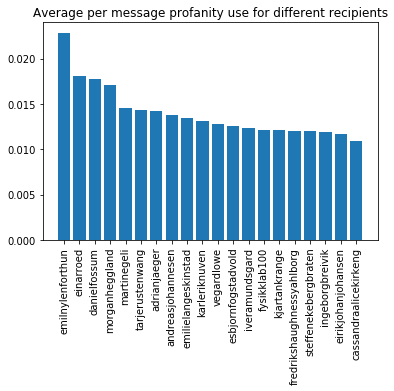

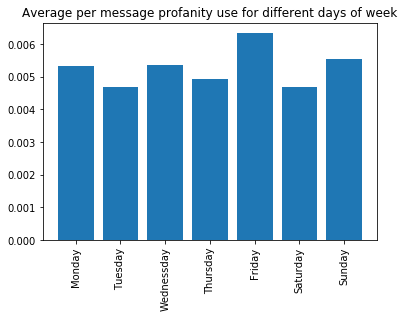

In [58]:
# plotting functions
def plot_word_counts():
    counts = dict(word_count.most_common(20))
    plt.bar(range(len(counts)), list(counts.values()), align='center')
    plt.xticks(range(len(counts)), list(counts.keys()), rotation='vertical')
    plt.title('Frequency of use for each unique word')
    plt.show()

def plot_profanity_per_chat():
    counts = dict(chat_profanity_ratios[:20])
    plt.bar(range(len(counts)), list(counts.values()), align='center')
    plt.xticks(range(len(counts)), list(counts.keys()), rotation='vertical')
    plt.title('Average per message profanity use for different recipients')
    plt.show()

def plot_profanity_per_weekday():
    counts = weekday_profanity_ratios
    plt.bar(range(len(counts)), list(counts.values()), align='center')
    plt.xticks(range(len(counts)), list(counts.keys()), rotation='vertical')
    plt.title('Average per message profanity use for different days of week')
    plt.show()
    
def plot():
    plot_word_counts()
    plot_profanity_per_chat()
    plot_profanity_per_weekday()

plot()

## Key takeaways
There are 3 things I've learned:
- My chat messages almost follow Zipf's law. However, my most frequent word is not used two times as often as the next one on the list, so it doesn't actually hold all that well.
- Emil Nylen-Forthun (the leftmost person in the second barchart) brings out the worst in me, and I apparently swear in a whopping 2.2% of the messages I send to him.
- Fridays are great for swearing, but only marginally.